### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sin, cos, pi
import tensorflow.keras as keras

In [3]:
# ---- About dataset
#
max_t        = 1000
delta_t      = 0.02
features_len = 2


sequence_len = 20
predict_len  = 5

# ---- About training
#
scale         = 1        # Percentage of dataset to be used (1=all)
train_prop    = .8       # Percentage for train (the rest being for the test)
batch_size    = 32
epochs        = 5
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

### Generate the data (the trajectory)

In [4]:
def ladybug_move(t):
    k=0.5
    random.seed(12)
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = [random.gauss(0.,1.) for u in range(8)]
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = [random.gauss(0.5,1.) for u in range(8)]
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 

    return x,y

In [5]:
positions = []
for t in np.arange(0, max_t, delta_t):
    x, y = ladybug_move(t)
    positions.append([x, y])

positions = np.array(positions)

### Plot the trajectory

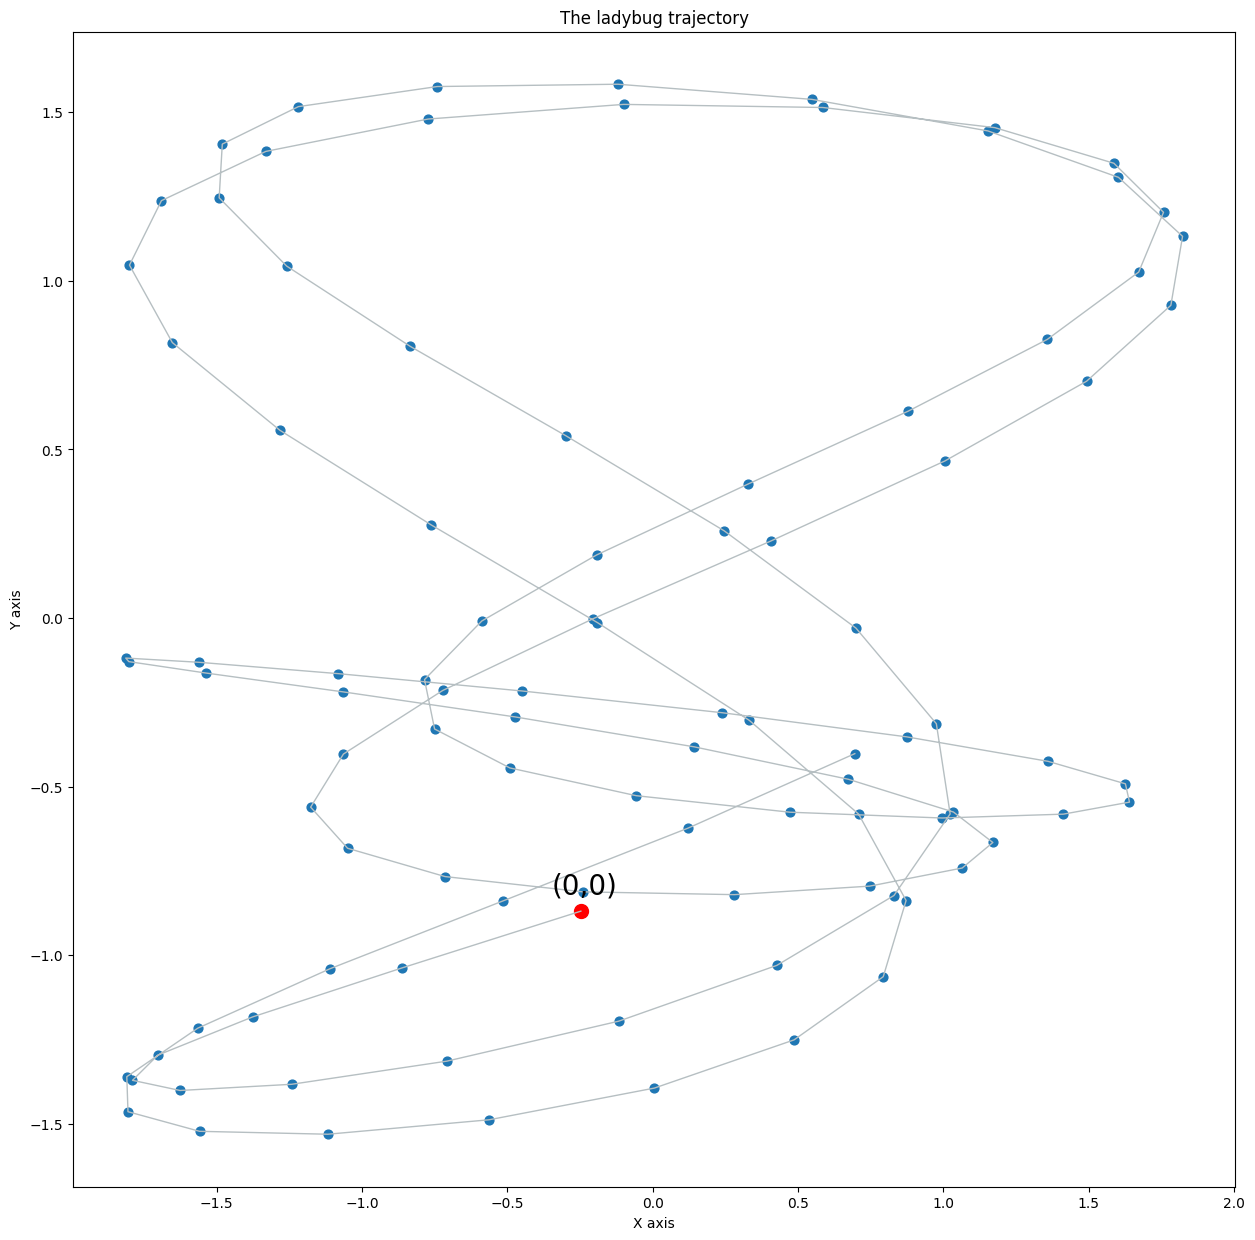

In [6]:
plt.figure(figsize=(15, 15))
plt.plot(positions[:100,0], positions[:100,1], color='#b6bfc2', linewidth=1)
plt.scatter(positions[:100,0], positions[:100,1], s=40)
plt.text(positions[0,0]-0.1, positions[0,1]+0.05, '(0,0)', fontsize=20)
plt.scatter(positions[0,0], positions[0,1], c='r', s=100)

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('The ladybug trajectory')
plt.show()

### Split the data, and make it as sequences

In [7]:
split_index = int(train_prop * len(positions))
x_train = positions[:split_index]
x_test = positions[split_index:]

In [8]:
train_generator = keras.preprocessing.sequence.TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = keras.preprocessing.sequence.TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

### Build and train the model

In [9]:
# Build the model
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(sequence_len, features_len)))
#model.add(keras.layers.GRU(200, dropout=0.5, recurrent_dropout=0.5, return_sequences=False, activation='relu'))
model.add(keras.layers.GRU(200, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(features_len))

model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               122400    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 122802 (479.70 KB)
Trainable params: 122802 (479.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Train the model
history = model.fit(train_generator, 
                    epochs  = epochs, 
                    verbose = fit_verbosity,
                    validation_data = test_generator)

Epoch 1/5
1250/1250 [==============================] - 31s 23ms/step - loss: 0.0252 - mae: 0.0882 - val_loss: 0.0019 - val_mae: 0.0356
Epoch 2/5
1250/1250 [==============================] - 27s 22ms/step - loss: 0.0018 - mae: 0.0337 - val_loss: 7.7793e-04 - val_mae: 0.0228
Epoch 3/5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.0010 - mae: 0.0257 - val_loss: 6.5750e-04 - val_mae: 0.0211
Epoch 4/5
1250/1250 [==============================] - 28s 22ms/step - loss: 7.1466e-04 - mae: 0.0213 - val_loss: 6.0013e-04 - val_mae: 0.0204
Epoch 5/5
1250/1250 [==============================] - 30s 24ms/step - loss: 5.7202e-04 - mae: 0.0191 - val_loss: 1.3708e-04 - val_mae: 0.0094


In [26]:
# Save the model
model.save('ladybug_trajectory_model')

INFO:tensorflow:Assets written to: ladybug_trajectory_model\assets


INFO:tensorflow:Assets written to: ladybug_trajectory_model\assets


In [27]:
# Load the model
loaded_model = keras.models.load_model('ladybug_trajectory_model')

### Test the model 

1/1 [==============================] - 0s 36ms/step


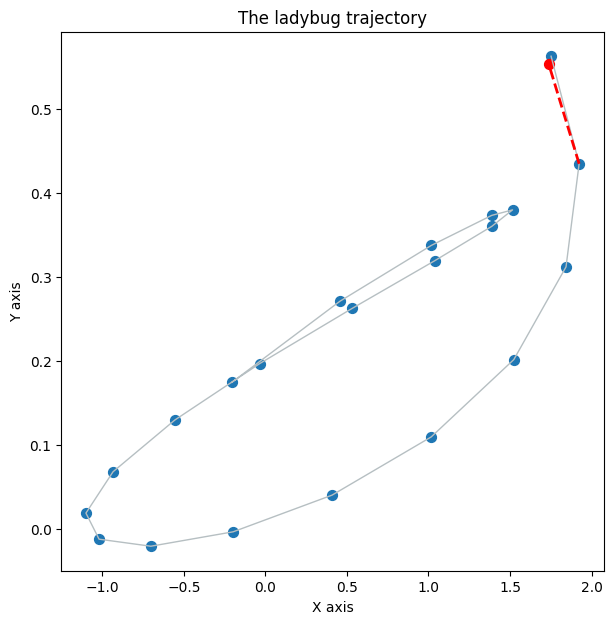

In [32]:
# Predict the ladybug trajectory

# we choose a random position to predict
s = random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = model.predict(np.array([sequence]))

plt.figure(figsize=(7, 7))

plt.plot(sequence_true[:,0], sequence_true[:,1], color='#b6bfc2', linewidth=1)
plt.scatter(sequence_true[:,0], sequence_true[:,1], s=50)

plt.scatter(sequence_pred[0][0], sequence_pred[0][1], c='r', s=50)

plt.plot([sequence[-1][0], sequence_pred[0][0]], [sequence[-1][1], sequence_pred[0][1]], 'r--', linewidth=2)

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('The ladybug trajectory')
plt.show()